In [1]:
!nvidia-smi
%matplotlib inline

Thu Jun 26 16:22:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:32:00.0 Off |                    0 |
| N/A   31C    P0             50W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

# Loading Files

In [2]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

# Prompt Setting

In [4]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

# Qwen3 4B

## Loading the model

In [5]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

cuda


## Defining helper Functions after loading a model

In [7]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=5,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## Implementation

In [8]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [9]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [1:51:07<00:00, 28.86s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user provided a ...","{\n ""query"": ""The idea that the united states...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking ""...","{\n ""query"": ""How many times french won the w...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""When was pink floyd's dark side...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""When did leonardo da vinci fini...",underspecified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking f...","{\n ""query"": ""Who is the first speaker of nat...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Is Pensacola sylvestris a multi...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the leaf mass per area o...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When did Patsyella make its las...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the body mass of Salaman...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.68      0.68      0.68       598
 underspecified       0.66      0.65      0.65       557

       accuracy                           0.67      1155
      macro avg       0.67      0.67      0.67      1155
   weighted avg       0.67      0.67      0.67      1155



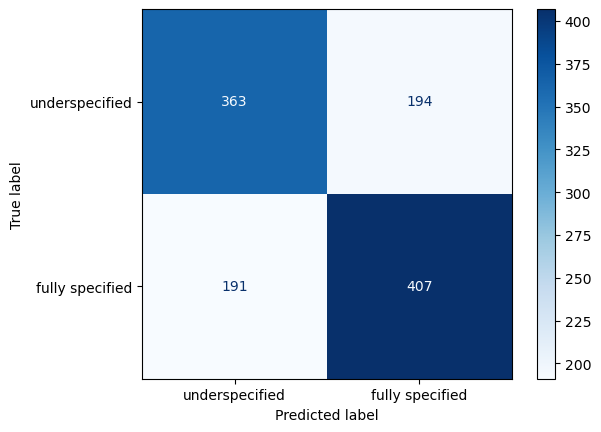

In [10]:
retrieve_results(test_df, "Qwen3_4B_FS_UND")

In [4]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    
    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [5]:
obtain_results_without('Qwen3_4B_FS_UND.csv', 'AmbigQA')

                 precision    recall  f1-score   support

fully specified       0.73      0.66      0.69       431
 underspecified       0.69      0.75      0.72       424

       accuracy                           0.71       855
      macro avg       0.71      0.71      0.70       855
   weighted avg       0.71      0.71      0.70       855



# Qwen 3 8B

## Loading the model

In [5]:
Qwen3_8B = "Qwen/Qwen3-8B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_8B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_8B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

cuda


## Implementation

In [9]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [10]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [2:37:23<00:00, 40.88s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"<think>\nOkay, let's see here. The user provid...","{\n ""query"": ""The idea that the united states...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many times French won the w...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"<think>\nOkay, let me tackle this query. The u...","{\n ""query"": ""When was pink floyd's dark side...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user asked when ...","{\n ""query"": ""When did leonardo da vinci fini...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the first speaker of nat...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Is Pe...","{\n ""query"": ""Is Pensacola sylvestris a multi...",underspecified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the leaf mass per area o...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When did Patsyella make its las...",underspecified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the body mass of Salaman...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.68      0.58      0.63       598
 underspecified       0.61      0.71      0.65       557

       accuracy                           0.64      1155
      macro avg       0.64      0.64      0.64      1155
   weighted avg       0.65      0.64      0.64      1155



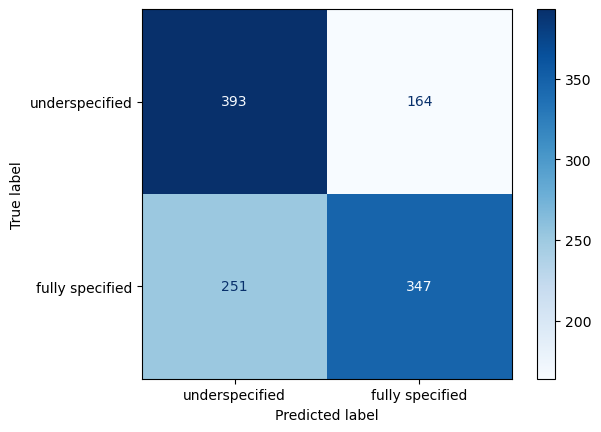

In [11]:
retrieve_results(test_df, "Qwen3_8B_FS_UND")

In [6]:
obtain_results_without('Qwen3_8B_FS_UND.csv', 'AmbigQA')

                 precision    recall  f1-score   support

fully specified       0.74      0.56      0.63       431
 underspecified       0.64      0.80      0.71       424

       accuracy                           0.68       855
      macro avg       0.69      0.68      0.67       855
   weighted avg       0.69      0.68      0.67       855



# Qwen3 14B

## Loading the model

In [5]:
Qwen3_14B = "Qwen/Qwen3-14B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_14B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_14B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

cuda


## Implementation

In [9]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [10]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [1:49:27<00:00, 28.43s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""The idea that the united states...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"<think>\nOkay, let's see here. The user asked,...","{\n ""query"": ""How many times french won the w...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"<think>\nOkay, let me look at this query. The ...","{\n ""query"": ""When was pink floyd's dark side...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When did leonardo da vinci fini...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"<think>\nOkay, let's take a look at this query...","{\n ""query"": ""Who is the first speaker of nat...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Is Pe...","{\n ""query"": ""Is Pensacola sylvestris a multi...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"<think>\nOkay, let me try to figure this out. ...","{\n ""query"": ""What's the leaf mass per area o...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"<think>\nOkay, let's take a look at this query...","{\n ""query"": ""When did Patsyella make its las...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"<think>\nOkay, let me think about this. The us...","{\n ""query"": ""What's the body mass of Salaman...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.65      0.77      0.70       598
 underspecified       0.69      0.55      0.61       557

       accuracy                           0.66      1155
      macro avg       0.67      0.66      0.65      1155
   weighted avg       0.66      0.66      0.66      1155



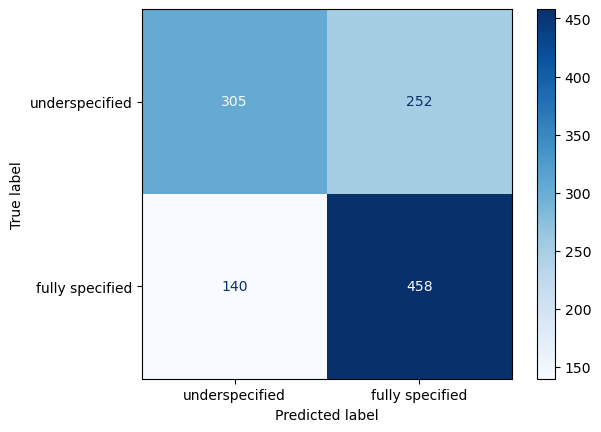

In [11]:
retrieve_results(test_df, "Qwen3_14B_FS_UND")

In [7]:
obtain_results_without('Qwen3_14B_FS_UND.csv', 'AmbigQA')

                 precision    recall  f1-score   support

fully specified       0.68      0.77      0.72       431
 underspecified       0.73      0.63      0.67       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855



# Qwen3 32B

## Loading the model 1

In [6]:
Qwen3_32B = "Qwen/Qwen3-32B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_32B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_32B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

## Loading the model 2

In [5]:
Qwen_32B = "Qwen/Qwen3-32B"

"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

'\nmodule load CUDA/12.4.0\nsource ~/sglang-venv-2/bin/activate\nhuggingface-cli login\n\n\n# 创建所有必要的目录\nmkdir -p /scratch-local/yhuang/sglang_cache\nmkdir -p /scratch-local/yhuang/huggingface_cache\nmkdir -p /scratch-local/yhuang/torch_cache\nmkdir -p /scratch-local/yhuang/cuda_cache\nmkdir -p /scratch-local/yhuang/xdg_cache\nmkdir -p /scratch-local/yhuang/tmp\nmkdir -p /scratch-local/yhuang/logs\n\n# 设置所有相关环境变量\nexport SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache\nexport TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache\nexport HF_HOME=/scratch-local/yhuang/huggingface_cache\nexport HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets\nexport TORCH_HOME=/scratch-local/yhuang/torch_cache\nexport CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache\nexport XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache\nexport TMPDIR=/scratch-local/yhuang/tmp\nexport TEMP=/scratch-local/yhuang/tmp\nexport TMP=/scratch-local/yhuang/tmp\nexport SGLANG_LOG_DIR=/scratch-local/yhua

In [6]:
import openai
import re
client = openai.Client(
    base_url="http://localhost:7501/v1", api_key="EMPTY")


def batch_generate_responses_openai(prompts, system_prompt=system_prompt,
                            temperature=0.7, max_new_tokens=32768, batch_size=5,
                            enable_thinking=True):
    responses = []
    thoughts = []

    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_responses = []
        batch_thoughts = []

        for prompt in batch_prompts:
            try:
                kwargs = {
                    "model": "Qwen/Qwen3-32B",
                    "messages": [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": prompt},
                    ],
                    "temperature": temperature,
                    "max_tokens": max_new_tokens,
                    "extra_body": {"chat_template_kwargs": {"enable_thinking": False}}
                }

                # 仅当enable_thinking为True时添加思考模式参数
                if enable_thinking:
                    kwargs["extra_body"] = {"chat_template_kwargs": {"enable_thinking": True}}

                response = client.chat.completions.create(**kwargs)
                full_text = response.choices[0].message.content

                # 仅在enable_thinking为True时尝试分离思考过程
                if enable_thinking:
                    try:
                        end_think_pos = full_text.find('</think>')

                        if end_think_pos != -1:
                            thought = full_text[:end_think_pos].strip()
                            answer = full_text[end_think_pos + len('</think>'):].strip()
                        else:
                            thought = ""
                            answer = full_text
                    except Exception as parsing_error:
                        print(f"解析思考过程时出错: {parsing_error}")
                        thought = ""
                        answer = full_text
                else:
                    # 当enable_thinking为False时，不分离思考过程
                    thought = ""
                    answer = full_text

                batch_responses.append(answer)
                batch_thoughts.append(thought)

            except Exception as e:
                print(f"API调用时出错: {e}")
                batch_responses.append(None)
                batch_thoughts.append(None)

        responses.extend(batch_responses)
        thoughts.extend(batch_thoughts)

    return responses, thoughts


def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_openai(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[1]
  df['model_response'] = output[0]
  to_process = output[0]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## Implementation

### For Loading 1

In [10]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [ ]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

In [ ]:
retrieve_results(test_df, "Qwen3_32B_FS_UND")

### For Loading 2

#### A pilot test

In [7]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [8]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [01:39<00:00, 33.33s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,thinking,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"<think>\nOkay, let's analyze this user query. ...","{""query"": ""When did the nuclear accident happe...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"<think>\nOkay, let's analyze this user query. ...","{""query"": ""I need help picking out a professio...",fully specified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{""query"": ""When did the apple tv 4k come out?""...",fully specified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"<think>\nOkay, let's analyze the user query ""W...","{""query"": ""Who sings i love rock 'n' roll? ...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"<think>\nOkay, let's see. The user is asking a...","{""query"": ""Where does the new fallout game tak...",underspecified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"<think>\nOkay, let's look at this user query. ...","{""query"": ""Who is the existing prime minister?...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's take a look at this query...","{""query"": ""Who played the king in game of thro...",underspecified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, I need to determine if the quer...","{""query"": ""Who plays henry tudor in the white ...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking ""...","{""query"": ""Who won the contest to design the c...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"<think>\nOkay, let's see. The user is asking, ...","{""query"": ""How many daughters do George Washin...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.50      0.50      0.50         6
 underspecified       0.50      0.50      0.50         6

       accuracy                           0.50        12
      macro avg       0.50      0.50      0.50        12
   weighted avg       0.50      0.50      0.50        12



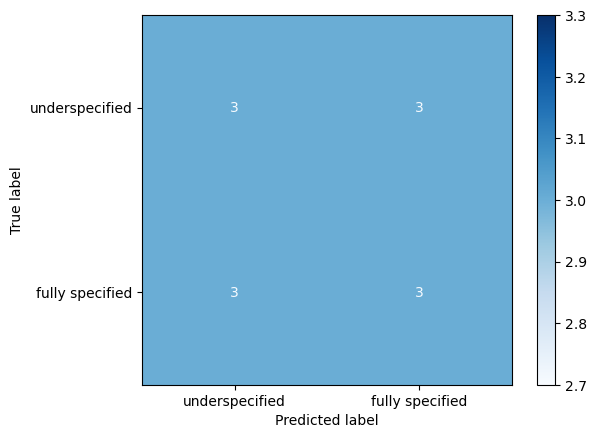

In [9]:
retrieve_results(test_df, "Qwen3_32B_FS_UND_pilot")

#### 噶事

In [7]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [8]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [2:48:03<00:00, 43.65s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"<think>\nOkay, let's take a look at this query...","{""query"": ""The idea that the united states was...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking, ...","{""query"": ""How many times french won the world...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{""query"": ""When was pink floyd's dark side of ...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{""query"": ""When did leonardo da vinci finish p...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"<think>\nOkay, I need to analyze the query ""Wh...","{""query"": ""Who is the first speaker of nationa...",fully specified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking w...","{""query"": ""Is Pensacola sylvestris a multicell...",underspecified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking a...","{""query"": ""What's the leaf mass per area of La...",underspecified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking w...","{""query"": ""When did Patsyella make its last ap...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"<think>\nOkay, I need to determine if the quer...","{""query"": ""What's the body mass of Salamandra ...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.65      0.74      0.69       598
 underspecified       0.67      0.58      0.62       557

       accuracy                           0.66      1155
      macro avg       0.66      0.66      0.66      1155
   weighted avg       0.66      0.66      0.66      1155



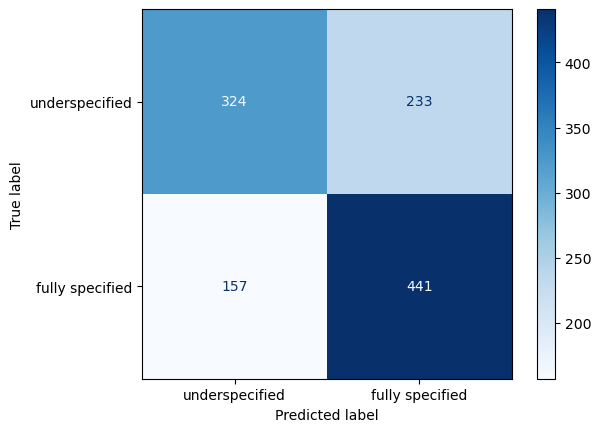

In [9]:
retrieve_results(test_df, "Qwen3_32B_FS_UND")

In [8]:
obtain_results_without('Qwen3_32B_FS_UND.csv', 'AmbigQA')

                 precision    recall  f1-score   support

fully specified       0.70      0.71      0.70       431
 underspecified       0.70      0.68      0.69       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855

